# Plotting
Some extra plots, like WGAN losses.

In [19]:
import wandb
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.signal import savgol_filter

## Comparing the 2 wgan training runs (same ones as fid scores)

In [2]:
api = wandb.Api()
run_experiment_1 = api.run("indooradventurer/udl_2025_diffusion_gan/runs/ddmig4t8")
run_experiment_2B = api.run("indooradventurer/udl_2025_diffusion_gan/runs/4xpqyyhv")

In [3]:
history_keys = ["epoch", "val/loss_critic", "val/loss_generator"]
experiment_1 = run_experiment_1.history(keys=history_keys)
experiment_2B = run_experiment_2B.history(keys=history_keys)

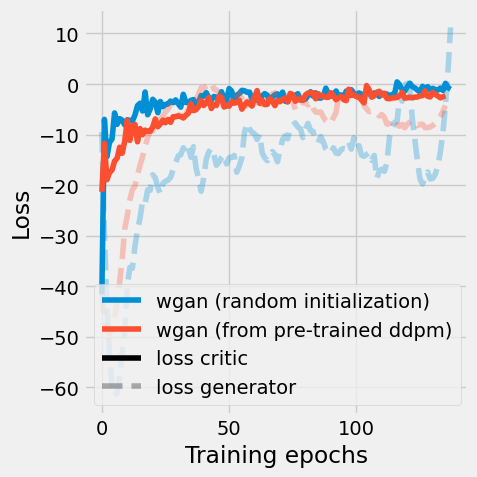

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
savgol_filter_window = 17

lines = []

color = colors[0]
lines += plt.plot(experiment_1["epoch"], experiment_1["val/loss_critic"], color=color, label="wgan (random initialization)")
plt.plot(experiment_1["epoch"], savgol_filter(experiment_1["val/loss_generator"], savgol_filter_window, 3), linestyle="dashed", color=color, alpha=0.3)

color = colors[1]
lines += plt.plot(experiment_2B["epoch"], experiment_2B["val/loss_critic"], color=color, label="wgan (from pre-trained ddpm)")
plt.plot(experiment_2B["epoch"], savgol_filter(experiment_2B["val/loss_generator"], savgol_filter_window, 3), linestyle="dashed", color=color, alpha=0.3)

lines += [
    Line2D([0], [0], color="black", label="loss critic"),
    Line2D([0], [0], color="black", linestyle="dashed", label="loss generator", alpha=0.3)
]


plt.legend(lines, [l.get_label() for l in lines])
plt.xlabel("Training epochs")
plt.ylabel("Loss")

plt.tight_layout()

plt.show()

## Plotting images

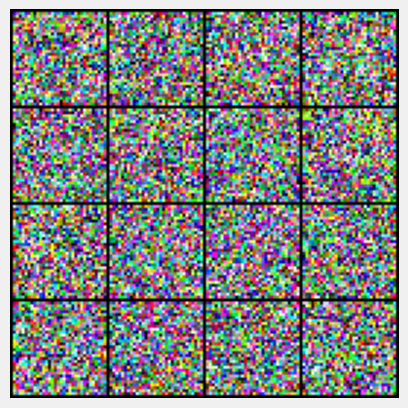

In [50]:
import torchvision
import torch

dummy = torch.randn((16,3,32,32))

def plot_4x4_grid(sample):
    grid = torchvision.utils.make_grid(sample * 0.5 + 0.5, 4, 1)
    grid = grid.clamp(0, 1)
    plt.imshow(grid.detach().cpu().transpose(0,2))
    plt.axis('off')

plot_4x4_grid(dummy)

In [51]:
import os
import sys
sys.path.append("../")

# from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms
from udl_2024_package.nn import unet_factory, SimpleDiscriminator
from udl_2024_package.vincent_wgan import WGANWithGradientPenalty
from udl_2024_package.vincent_diffusion import DiffusionModel

# from torchvision import datasets
# from torchvision.transforms import transforms
# from torch.utils.data import DataLoader

# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_02_wgan_finetune"

checkpoint_dir = "./experiment_02_wgan_finetune_models/"

config = {
    # Input data and training:
    "batch_size": 64,
    
    # "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
        "extra_transforms": [], # Warning: change when changing dataset

    # "dataset_cls": datasets.MNIST,
    #     "ds_name": "mnist",     # Warning: change when changing dataset
    #     "num_channels": 1,      # Warning: change when changing dataset
    #     "img_size": 32,         # Warning: change when changing dataset
    #     "extra_transforms": [   # Warning: change when changing dataset
    #         transforms.Resize(32)
    #     ],
    
    "max_epochs": 150,
    "dl_num_workers": 4,

    # WGAN model (WGAN-GP paper defaults):
    "optimizer_cls": torch.optim.Adam,
    "optimizer_args": { "lr": 1e-4, "betas": (0.5, 0.99) },
    "gp_weight": 10,
    "critic_iterations": 5,
    "lr_scaling_factor": 0.2,

    # DDPM values (not really used, but for loading checkpoint):
    "ddpm_steps": 1000,
    "ddpm_beta_start": 0.0001,
    "ddpm_beta_end": 0.02,

    # U-Net config:
    "block_out_channels": [128, 256, 256, 256],
    "layers_per_block": 2,

    # Starting point for training:
    "unet_checkpoint": "./cifar10_peachy-totem-7_epochepoch=94.ckpt",

    # Critic config:
    "cri_channel_list": [128] * 4,
    "cri_kernel_list": [3] * 4,
    "cri_downsample_list": [True] * 2 + [False] * 2
}

datasets_path = os.path.join(os.environ.get("TMPDIR", os.curdir), "datasets")

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

In [52]:
diff_model = DiffusionModel.load_from_checkpoint(
    config["unet_checkpoint"],
    model=unet_factory(
        img_size=config["img_size"],
        img_channels=config["num_channels"],
        block_out_channels=config["block_out_channels"],
        layers_per_block=config["layers_per_block"]
    ),
    optimizer_cls=config["optimizer_cls"],
    optimizer_args=config["optimizer_args"],
    steps=config["ddpm_steps"],
    beta_start=config["ddpm_beta_start"],
    beta_end=config["ddpm_beta_end"],
).to("cuda")

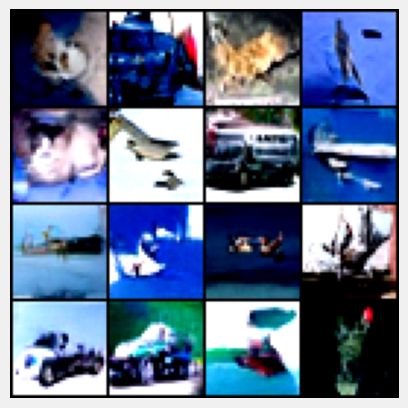

In [59]:
torch.manual_seed(1967)
with torch.no_grad():
    samples = diff_model.sample_img((16, 3, 32, 32))
plot_4x4_grid(samples.transpose(-1,-2))

In [61]:
del diff_model

In [79]:
def generate_samples(generator, real_batch):
    noise = torch.randn_like(real_batch)
    ts = torch.full((len(real_batch),), 999, device=real_batch.device)
    return generator(noise, ts)

def load_checkpoint(path):
    unet = unet_factory(
        img_size=config["img_size"],
        img_channels=config["num_channels"],
        block_out_channels=config["block_out_channels"],
        layers_per_block=config["layers_per_block"]
    )

    critic = SimpleDiscriminator(
        in_channels=config["num_channels"],
        channel_list=config["cri_channel_list"],
        kernel_list=config["cri_kernel_list"],
        downsample_list=config["cri_downsample_list"]
    )

    model = WGANWithGradientPenalty.load_from_checkpoint(
        path,
        generator=unet,
        critic=critic,
        generator_func=generate_samples,
        optimizer_cls=config["optimizer_cls"],
        optimizer_args=config["optimizer_args"],
        gp_weight=config["gp_weight"],
        critic_iterations=config["critic_iterations"],
        lr_scaling_factor=config["lr_scaling_factor"]
    )
    return model.gen.to("cuda")

gan_generator = load_checkpoint("./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=24.ckpt")

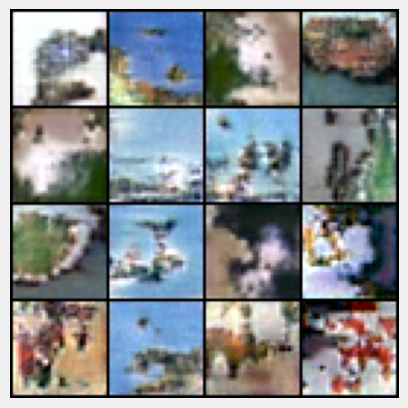

In [80]:
with torch.no_grad():
    samples = generate_samples(gan_generator, samples)
plot_4x4_grid(samples.transpose(-1,-2))